# Housing Price Prediction Model using Ridge and Lasso regularization

## Introduction

In this notebook we are going to build regression model to predict the housing prices based on the data collected by the company from their australian market. The dataset contains various parameters defining the location, size, and other features of the houses and the house's price.

We are going to use Ridge and Lasso regularization methods to keep the model optimally fit and using Lasso we will also try to determine which insignificant predictors can be dropped.

The data is available in [train.csv](data/train.csv) and the data dictionary is in [data_dictionary.txt](data/data_dictionary.txt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  r2_score

import os
import warnings
warnings.filterwarnings('ignore')


## Data Exploration

In this section we will explore the dataset and will cleanup the columns / rows which are majority empty

In [2]:
housing = pd.read_csv("data/train.csv")
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Removing empty/unwanted Columns & Rows

In [4]:
# Drop Id column
housing.drop(columns=['Id'],inplace=True)

In [5]:
# Find out the columns which are empty / NaN for more than 90% of rows, we can just drop them from the dataset
empty_cols = housing.columns[~(housing.isnull().sum(axis=0) <= housing.shape[0] * 0.9)].tolist()
housing.drop(columns=empty_cols,inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [6]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

LotFrontage      259
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
Fence           1179
dtype: int64

In [7]:
# Fence has 1179 rows with NaN which is roughly 80% of total records and hence it can't be signficant for model building, so lets drop that column from the dataset
housing.drop(columns=['Fence'],inplace=True)                      

In [8]:
housing[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']][housing['GarageFinish'].isna()]

# there are 81 rows which have garage values as NaN we can just drop these rows from dataset
housing.drop(housing[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']][housing['GarageFinish'].isna()].index,inplace=True)
housing.reset_index(drop=True, inplace=True)


In [9]:
housing['LotFrontage'].describe()

count    1127.000000
mean       70.683230
std        24.261598
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [10]:
# fill the missing values in LotFrontage to the mean of that column. It is the distance from street and given 75% is within 80 feet we can take mean which is 70 to fill the Null values
housing['LotFrontage'].fillna(housing['LotFrontage'].mean(), inplace=True)

In [11]:
# the stats are pretty much intact
housing['LotFrontage'].describe()

count    1379.000000
mean       70.683230
std        21.931281
min        21.000000
25%        60.000000
50%        70.683230
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [12]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

MasVnrType        8
MasVnrArea        8
BsmtQual         30
BsmtCond         30
BsmtExposure     31
BsmtFinType1     30
BsmtFinType2     31
Electrical        1
FireplaceQu     618
dtype: int64

In [13]:
# FireplaceQu has almost **50% rows Null / NaN** so lets analyze the remain 50% rows have any strong correlation with SalePrice.
# Lets analyze first the distribution of the values in that column and then find the correlation.
    
housing['FireplaceQu'].value_counts()

Gd    376
TA    310
Fa     33
Ex     24
Po     18
Name: FireplaceQu, dtype: int64

In [14]:
# generate dummy variables to find the correlation with SalePrice
fqdummy = pd.get_dummies(housing[~housing['FireplaceQu'].isna()][['FireplaceQu']], drop_first=True)
cp=pd.concat([fqdummy,housing[~housing['FireplaceQu'].isna()][['SalePrice']]],axis=1)
cp.corr()

,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,SalePrice
FireplaceQu_Fa,1.000000,-0.210404,-0.033139,-0.176516,-0.124060
FireplaceQu_Gd,-0.210404,1.000000,-0.153817,-0.819325,0.110838
FireplaceQu_Po,-0.033139,-0.153817,1.000000,-0.129043,-0.149835
FireplaceQu_TA,-0.176516,-0.819325,-0.129043,1.000000,-0.104177
SalePrice,-0.124060,0.110838,-0.149835,-0.104177,1.000000


In [15]:
# There is no strong correlation and therefore we can drop this entire column.
housing.drop(columns=['FireplaceQu'],inplace=True)
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

MasVnrType       8
MasVnrArea       8
BsmtQual        30
BsmtCond        30
BsmtExposure    31
BsmtFinType1    30
BsmtFinType2    31
Electrical       1
dtype: int64

In [16]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0).index

Index(['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical'],
      dtype='object')

In [17]:
# lets find out how many rows exist that have atleast one NaN value
housing[housing.isna().any(axis=1)][housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0).index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 17 to 1334
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MasVnrType    33 non-null     object 
 1   MasVnrArea    33 non-null     float64
 2   BsmtQual      11 non-null     object 
 3   BsmtCond      11 non-null     object 
 4   BsmtExposure  10 non-null     object 
 5   BsmtFinType1  11 non-null     object 
 6   BsmtFinType2  10 non-null     object 
 7   Electrical    40 non-null     object 
dtypes: float64(1), object(7)
memory usage: 2.9+ KB


In [18]:
# there are total 41 rows, which is around 3% of total records, hence we can drop these rows to make the dataset NaN free
print(f"Before dropping rows {housing.shape}")
print(f"No of NaN Values {housing.isna().sum().sum()}")
housing.drop(housing[housing.isna().any(axis=1)].index, inplace=True)
housing.reset_index(drop=True, inplace=True)
print(f"After dropping rows {housing.shape}")
print(f"No of NaN Values {housing.isna().sum().sum()}")


Before dropping rows (1379, 75)
No of NaN Values 169
After dropping rows (1338, 75)
No of NaN Values 0


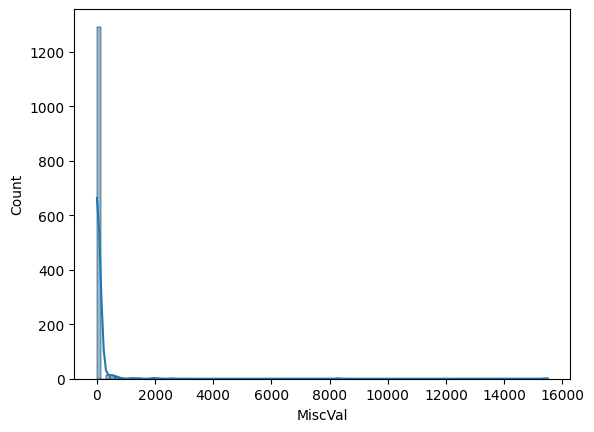

(47, 75)


In [19]:
# Analyze MiscVal column
sns.histplot(housing['MiscVal'], kde=True,bins=100)
plt.show()
print(housing[housing['MiscVal'] > 0].shape)

In [20]:
# There only 47 rows in this column have more than 0 amount. That is nearly 3% of total data and hence we can drop this column from our analysis.
housing.drop(columns=['MiscVal'],inplace=True)

### Analyze Categorical Data and Remove visibily insgnificant columns


In [21]:
for col in housing.select_dtypes(include=['object']).columns:
    print(f"### Column : {col} ###")
    print(housing[col].value_counts())
    print("\n")

### Column : MSZoning ###
RL         1066
RM          191
FV           62
RH           11
C (all)       8
Name: MSZoning, dtype: int64


### Column : Street ###
Pave    1333
Grvl       5
Name: Street, dtype: int64


### Column : LotShape ###
Reg    829
IR1    459
IR2     40
IR3     10
Name: LotShape, dtype: int64


### Column : LandContour ###
Lvl    1206
Bnk      52
HLS      48
Low      32
Name: LandContour, dtype: int64


### Column : Utilities ###
AllPub    1337
NoSeWa       1
Name: Utilities, dtype: int64


### Column : LotConfig ###
Inside     957
Corner     244
CulDSac     90
FR2         43
FR3          4
Name: LotConfig, dtype: int64


### Column : LandSlope ###
Gtl    1265
Mod      61
Sev      12
Name: LandSlope, dtype: int64


### Column : Neighborhood ###
NAmes      209
CollgCr    146
OldTown    100
Somerst     83
Gilbert     77
NridgHt     75
NWAmes      73
Edwards     70
Sawyer      69
SawyerW     53
Crawfor     50
BrkSide     47
Mitchel     42
NoRidge     41
Timber      37

#### Low Cardinality Columns and Cleanup

Upon visually inspecting the value counts distribution following columns can be easily ignored / dropped out of the main dataset. These columns have same values for more than 90% of records. Such variables can not describe the change in target variable's values.

* Street
* LandContour
* Utilities
* LandSlope
* Condition2
* RoofMatl
* BsmtCond
* Electrical
* Functional
* GarageQual
* GarageCond
* PavedDrive

In [22]:
# Lets drop these columns and create a new dataset (keeping housing as it is for any future reference)
print(housing.shape)
housing_cleaned = housing.drop(columns=['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive'])
print(housing_cleaned.shape)

(1338, 74)
(1338, 62)


#### Mix Cardinality Columns and Cleanup

Following columns have one value which is much higher than others however less than 90% of records. We can spend some time to analyze their correlation with SalePrice to ensure that we are not dropping the columns without due analysis.

* LotConfig 
* Condition1 
* BldgType 
* ExterCond 
* BsmtFinType2 
* SaleType 
* SaleCondition 

In [23]:
for c in ['MSZoning','LotConfig', 'Condition1', 'BldgType', 'ExterCond', 'BsmtFinType2', 'SaleType', 'SaleCondition']:
    dummy = pd.get_dummies(housing[c], drop_first=True)
    cp=pd.concat([dummy,housing['SalePrice']],axis=1)
    print(f"### Column : {c} ####")
    print(cp.corr())
    print("")

### Column : MSZoning ####
                 FV        RH        RL        RM  SalePrice
FV         1.000000 -0.020069 -0.436380 -0.089951   0.078595
RH        -0.020069  1.000000 -0.180242 -0.037153  -0.069507
RL        -0.436380 -0.180242  1.000000 -0.807847   0.243886
RM        -0.089951 -0.037153 -0.807847  1.000000  -0.286337
SalePrice  0.078595 -0.069507  0.243886 -0.286337   1.000000

### Column : LotConfig ####
            CulDSac       FR2       FR3    Inside  SalePrice
CulDSac    1.000000 -0.048934 -0.014705 -0.425606   0.139274
FR2       -0.048934  1.000000 -0.009978 -0.288797  -0.005460
FR3       -0.014705 -0.009978  1.000000 -0.086785   0.015073
Inside    -0.425606 -0.288797 -0.086785  1.000000  -0.078990
SalePrice  0.139274 -0.005460  0.015073 -0.078990   1.000000

### Column : Condition1 ####
              Feedr      Norm      PosA      PosN      RRAe      RRAn  \
Feedr      1.000000 -0.571165 -0.017240 -0.026679 -0.019289 -0.031292   
Norm      -0.571165  1.000000 -0.199

##### Summary and Cleanup

As per visual inspection, except SaleCondition all other columns have negligible correlation with SalePrice.

For SaleCondition the correlation is weaker however in order to give benefit of doubt we will keep this column for now in the cleaned dataset. 

Other columns we will drop.

In [24]:
housing_cleaned.drop(columns=['MSZoning','LotConfig', 'Condition1', 'BldgType', 'ExterCond', 'BsmtFinType2', 'SaleType'],inplace=True)

In [25]:
housing_cleaned.shape

(1338, 55)

### Inspect Numeric Category Columns

In [26]:
print(housing_cleaned['MSSubClass'].astype('category').value_counts())
print(housing_cleaned['OverallQual'].astype('category').value_counts())
print(housing_cleaned['OverallCond'].astype('category').value_counts())
print(housing_cleaned['YearBuilt'].astype('category').value_counts())
print(housing_cleaned['YearRemodAdd'].astype('category').value_counts())
print(housing_cleaned['MoSold'].astype('category').value_counts())
print(housing_cleaned['YrSold'].astype('category').value_counts())

20     502
60     294
50     129
120     86
160     61
70      57
80      57
30      51
90      28
190     21
85      19
75      14
45       9
180      6
40       4
Name: MSSubClass, dtype: int64
6     359
5     351
7     312
8     165
4      81
9      43
10     17
3       8
2       2
Name: OverallQual, dtype: int64
5    770
6    233
7    183
8     68
4     46
9     20
3     15
2      3
Name: OverallCond, dtype: int64
2005    64
2006    63
2004    53
2007    46
2003    42
        ..
1917     1
1913     1
1912     1
1882     1
2010     1
Name: YearBuilt, Length: 109, dtype: int64
1950    145
2006     90
2005     71
2007     71
2004     60
       ... 
1983      5
1986      5
1982      5
1951      4
1952      4
Name: YearRemodAdd, Length: 61, dtype: int64
6     235
7     215
5     187
4     127
8     112
3      94
10     84
11     75
9      55
1      52
12     52
2      50
Name: MoSold, dtype: int64
2009    308
2007    306
2006    291
2008    273
2010    160
Name: YrSold, dtype: int64


All of them have good distribution of values so we will keep these columns for further analysis.

### Analyze pure numeric columns

In [28]:
# list the numeric columns
housing_cleaned.select_dtypes(include=['float64', 'int64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

In [30]:
# after removing the columns which are numeric but categorical, following are the columns which are numeric
numeric_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']


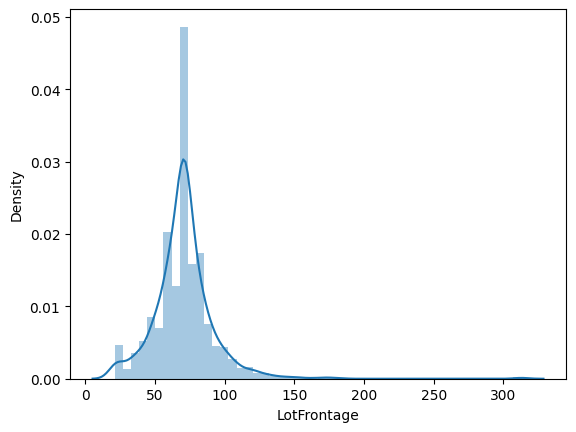

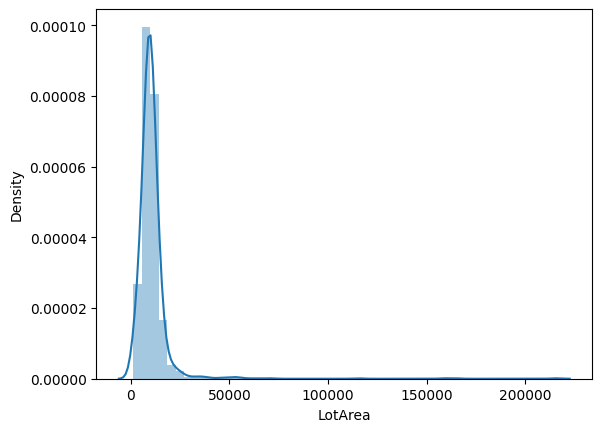

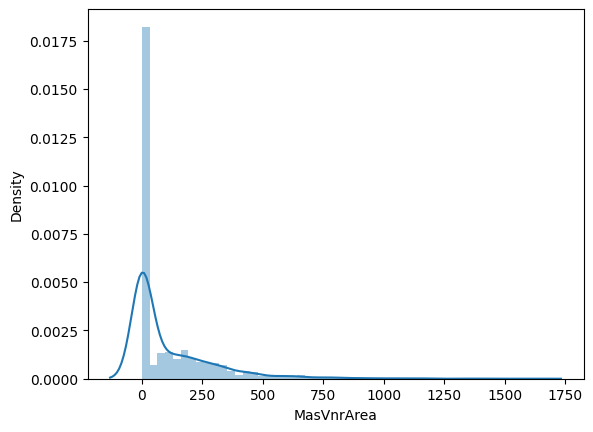

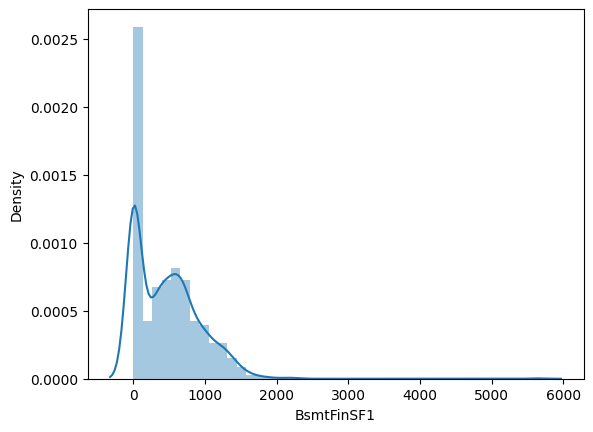

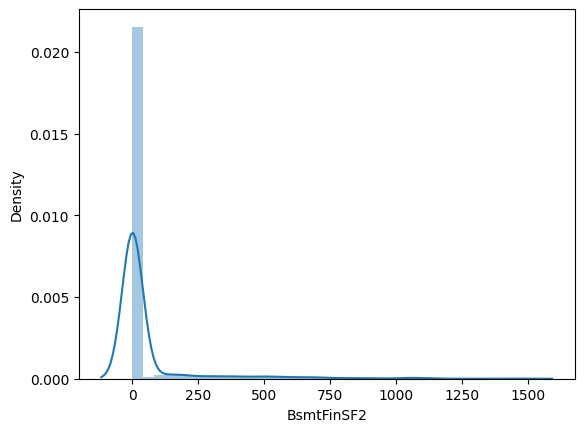

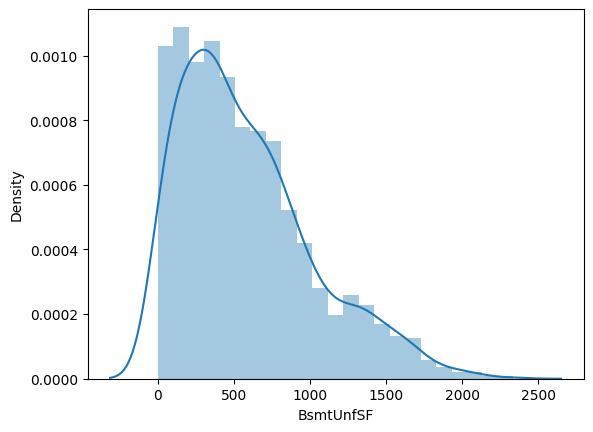

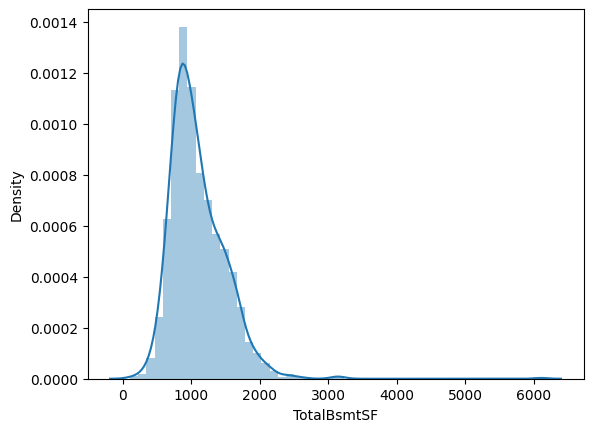

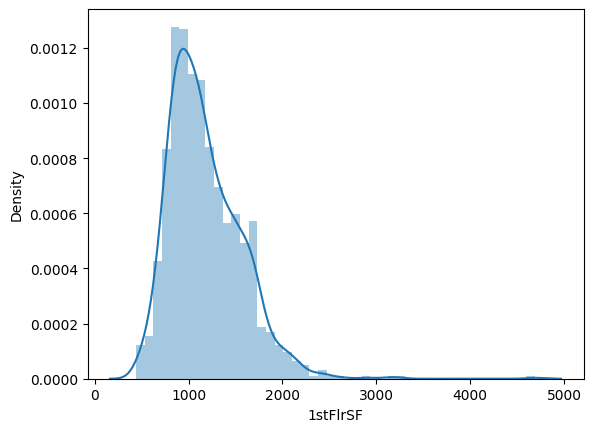

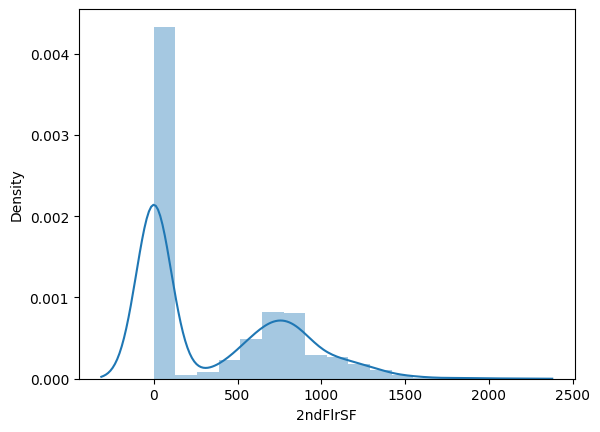

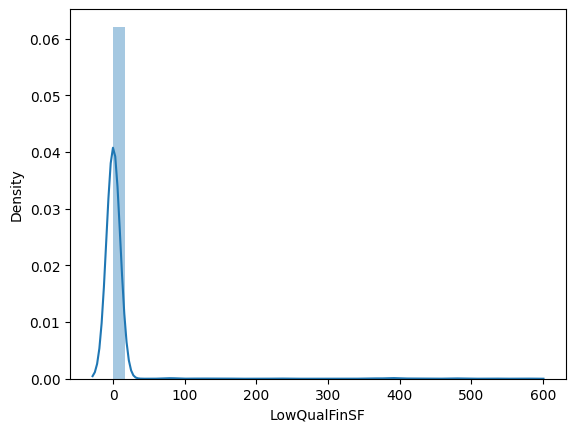

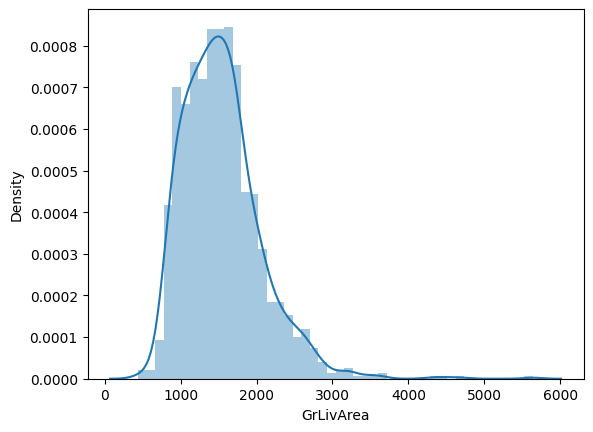

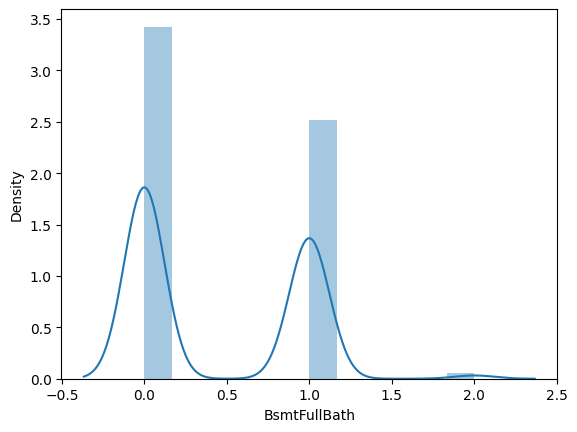

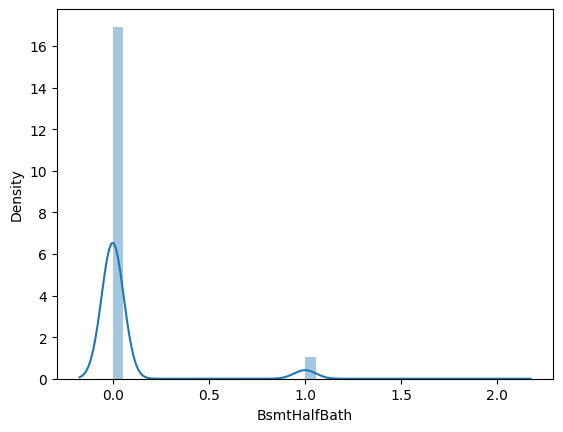

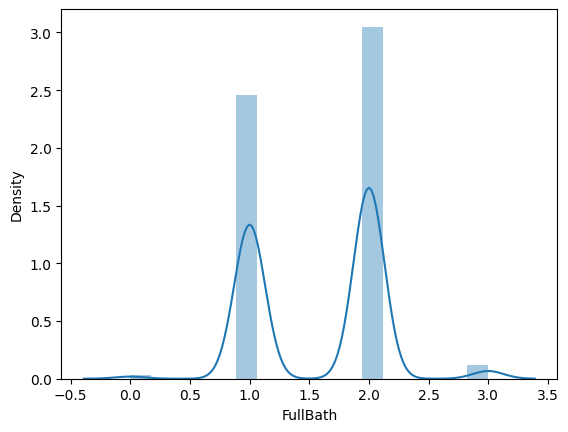

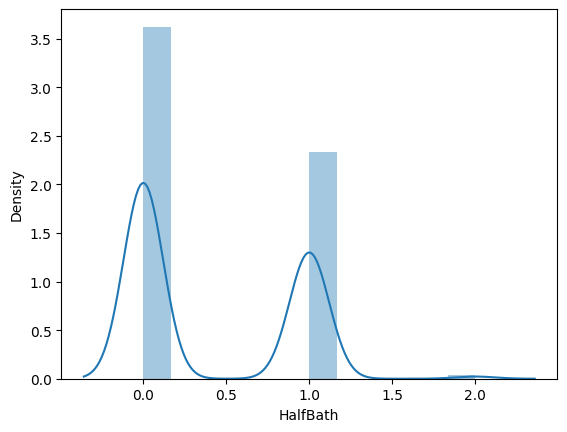

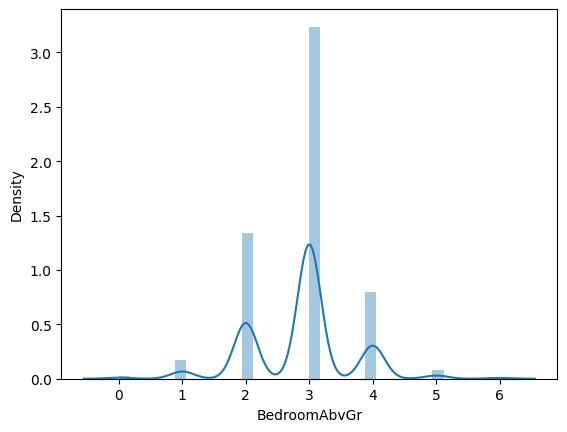

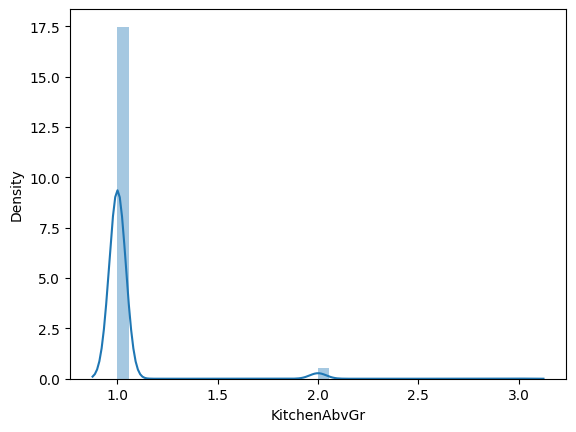

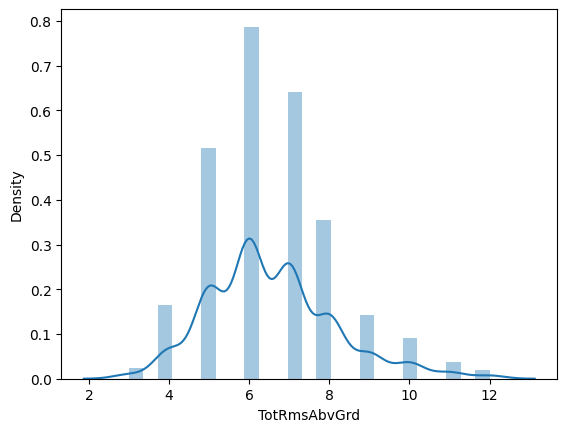

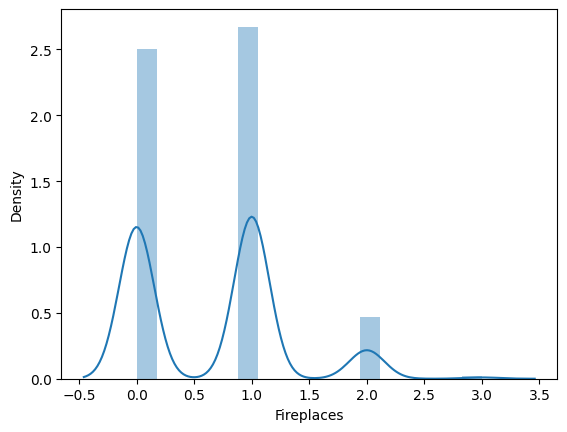

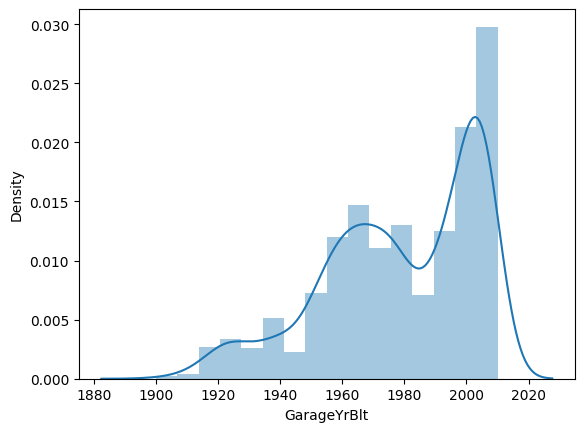

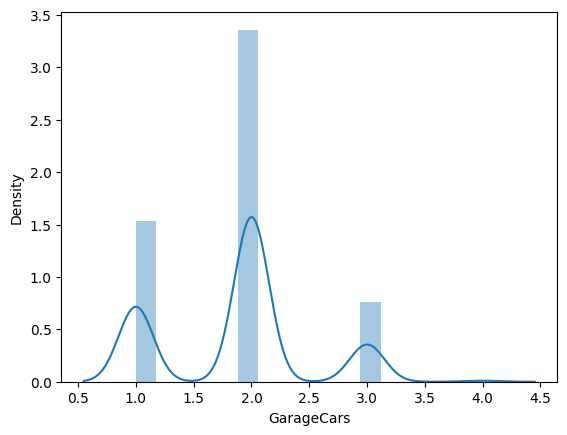

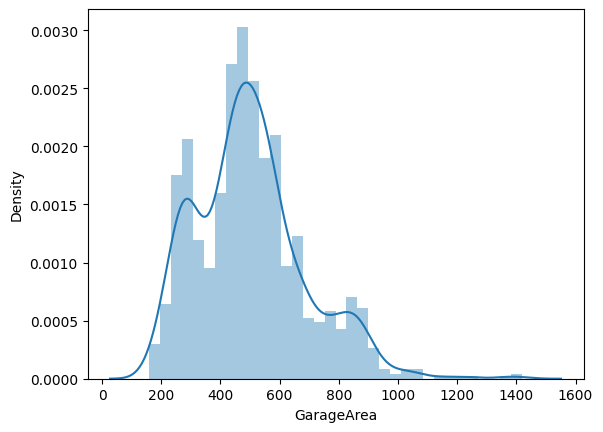

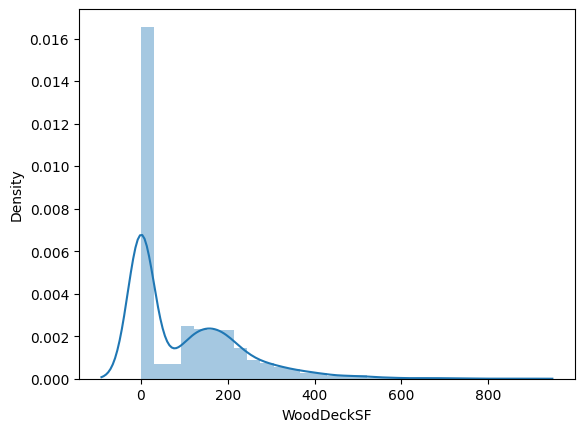

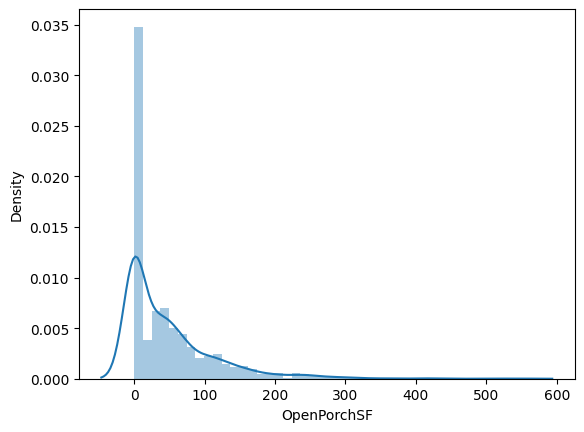

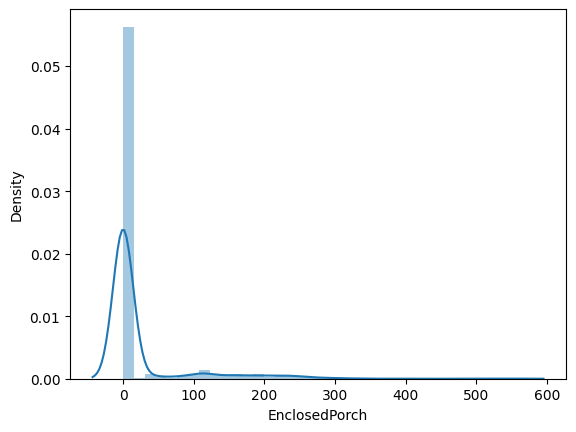

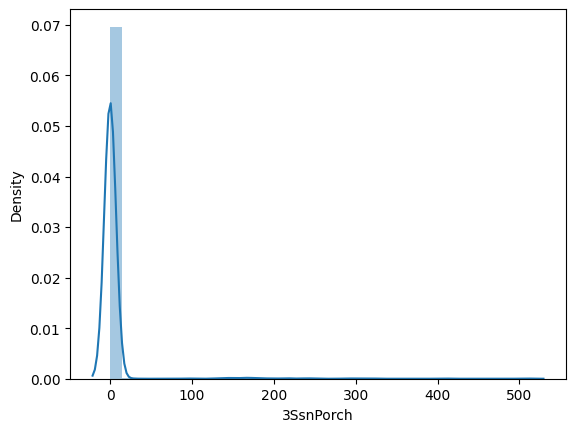

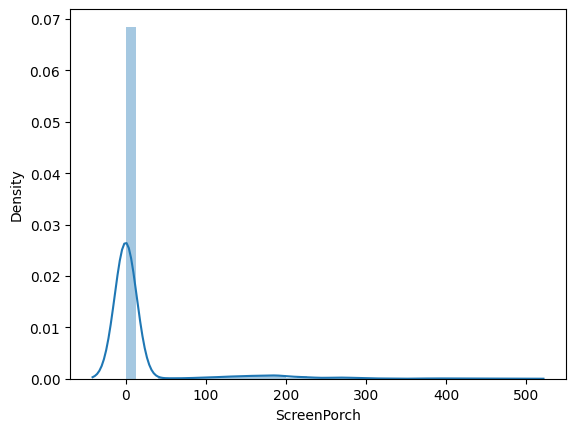

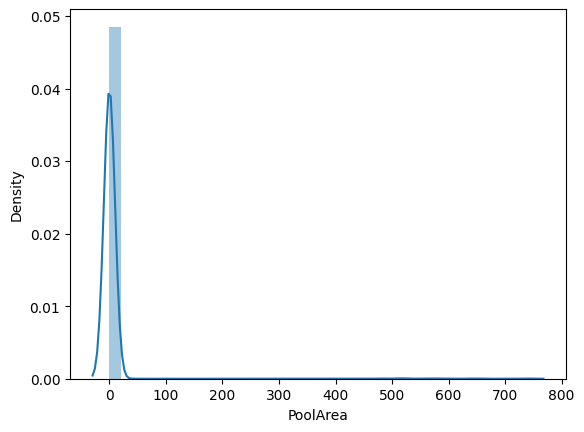

In [31]:
for c in numeric_cols:
    sns.distplot(housing_cleaned[c])
    plt.show()